In [79]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
import matplotlib.colors as mcolors

In [80]:
#laser
wavelength = 400*1e-09 #m 
#sipm
area_sipm = 36 # mm**2
pde = 0.5
crosstalk = 0.25
area_pm = np.pi * (11.3/ 2) ** 2  # clear aperture [mm]

In [81]:
def power_pm_cam_to_ph_pulse_sipm(power_pm, wavelength, rate, a_sipm, a_pm):
    """Converts the power measured at the PM Cam to the number of photons hitting the
    SiPM for each laser pulse, if the PM Cam and the camera are at the same distance
    from the uniform light source

    Parameters
    ----------
    power_pm : float (or np.array of floats)
        power measured by the PM Cam (W)
    wavelength : float
        light wavelength (m)
    rate : float
        laser rate (Hz)
    a_sipm : float
        SiPM area (mm**2)
    a_pm : float
        PM Cam area (mm**2)

    Returns
    -------
    float
        photon rate hitting the SiPM
    """
    ph_sipm = (
        power_pm
        / (constants.h * constants.c / wavelength)
        * (1 / rate)
        * (a_sipm / a_pm)
    )
    return ph_sipm

In [82]:
def attenuation(pm_las):
    pm_las_max = np.amax(pm_las)
    att = pm_las/pm_las_max
    return att

In [83]:

file1M = "./d20221207/d20221207_103436_calib/d20221207_103436_fw_scan.txt"
file600 = "./d20221207/d20221207_105058_calib/d20221207_105058_fw_scan.txt"

In [84]:
fw600, pm_las600, pm_cam600 = np.loadtxt(file600, comments="#", delimiter=" ", unpack=True)
fw1M, pm_las1M, pm_cam1M = np.loadtxt(file1M, comments="#", delimiter=" ", unpack=True)
att1M = attenuation(pm_las1M)
#print(att1M)
#print(pm_cam1M)

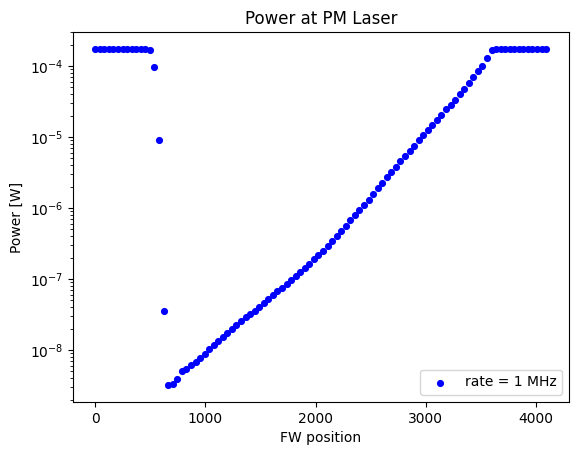

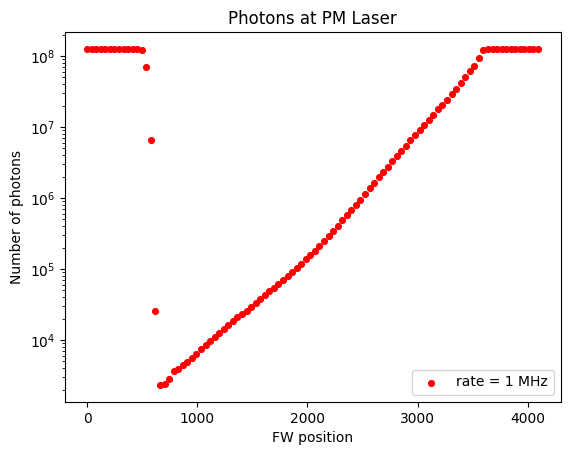

In [85]:
fig, ax = plt.subplots()
plt.scatter(fw1M, pm_las1M, c = "b", marker="o",s = 17, label = 'rate = 1 MHz')
ax.set_xlabel("FW position")
ax.set_ylabel("Power [W]")
ax.set_yscale("log")
plt.title("Power at PM Laser")
ax.legend(loc = 'lower right')
plt.show()

n_ph_las1M = power_pm_cam_to_ph_pulse_sipm(pm_las1M, wavelength, 1e06, area_sipm, area_pm)
fig, ax = plt.subplots()
plt.scatter(fw1M, n_ph_las1M, c = "r", marker="o",s = 17, label = 'rate = 1 MHz')
ax.set_xlabel("FW position")
ax.set_ylabel("Number of photons")
ax.set_yscale("log")
plt.title("Photons at PM Laser")
ax.legend(loc = 'lower right')
plt.show()

FIRST METHOD (ONLY POWERMETER MEASUREMENTS)

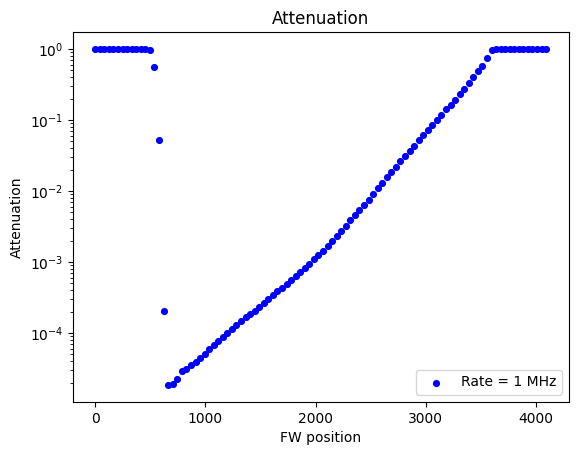

In [86]:
fig, ax = plt.subplots()
plt.scatter(fw1M, att1M, c = "b", marker="o",s = 17, label = 'Rate = 1 MHz')
ax.set_xlabel("FW position")
ax.set_ylabel("Attenuation")
ax.set_yscale("log")
plt.title("Attenuation")
ax.legend(loc = 'lower right')
plt.show()

Display the number of photons at 1 MHz at camera position evaluated directly from the raw power measurements


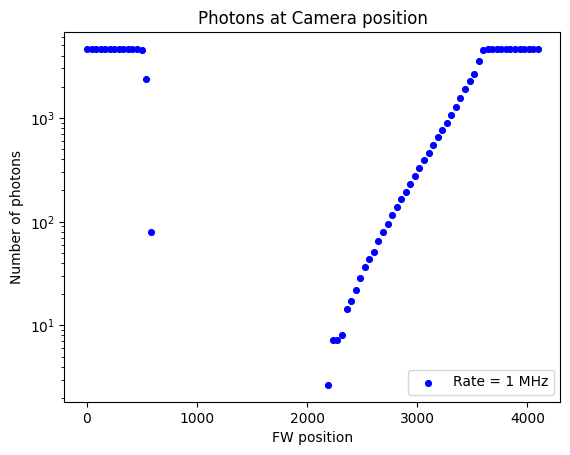

In [87]:
n_ph_cam_1M = power_pm_cam_to_ph_pulse_sipm(pm_cam1M, wavelength, 1e06, area_sipm, area_pm)

fig, ax = plt.subplots()
plt.scatter(fw1M, n_ph_cam_1M, c = "b", marker="o",s = 17, label = 'Rate = 1 MHz')
ax.set_xlabel("FW position")
ax.set_ylabel("Number of photons")
ax.set_yscale("log")
plt.title("Photons at Camera position")
ax.legend(loc = 'lower right')
plt.show()

Evaluate the expected number of photons via the factor k (averaged on fw positions where PM Cam sees some light)

In [88]:
#print(f"Number of photons at camera (from raw data): {n_ph_cam_1M}")
k = []
length = len(att1M)
for i in range(length):
    if n_ph_cam_1M[i] > 0:
        k.append(n_ph_cam_1M[i]/att1M[i])
#print(f"Factor k = n_ph_cam_1M / attenuation 1 M = {k}")
k_mean = np.mean(k)

print(f"Mean value of k = {k_mean}")

n_photons_1M_exp = np.multiply(att1M, k_mean)
#print(f"Expected number of photons at 1 MHz = {n_photons_1M_exp}")

Mean value of k = 4264.778901119589


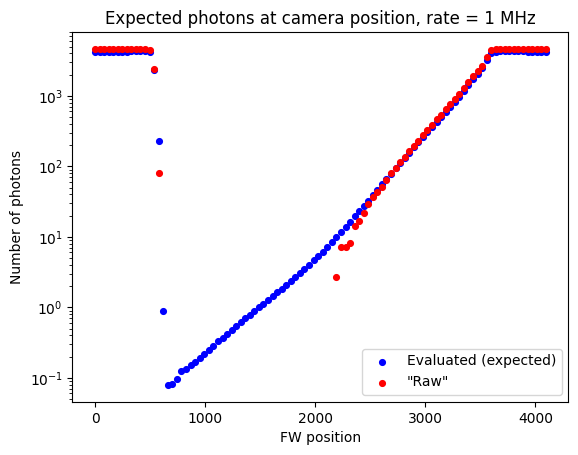

In [89]:
fig, ax = plt.subplots()
plt.scatter(fw1M, n_photons_1M_exp, c = "b", marker="o",s = 17, label = 'Evaluated (expected)')
plt.scatter(fw1M, n_ph_cam_1M, c = "r", marker="o",s = 17, label = '"Raw"')

ax.set_xlabel("FW position")
ax.set_ylabel("Number of photons")
ax.set_yscale("log")
plt.title("Expected photons at camera position, rate = 1 MHz")
ax.legend(loc = 'lower right')
plt.show()

Evaluate the expected number of photons at 600 Hz: I need to calculate the factor between measurements at 1 MHz and 600 Hz.

n_photons @ 600 Hz = [(n_photons @ 600 Hz @ LASER)/(n_photons @ 1 MHz @ LASER)] * n_photons @ 1 MHz @ CAMERA (exp.)

In [90]:
fac = []
length = len(pm_las1M)
n_ph_las_1M = power_pm_cam_to_ph_pulse_sipm(pm_las1M, wavelength, 1e06, area_sipm, area_pm)
n_ph_las_600 = power_pm_cam_to_ph_pulse_sipm(pm_las600, wavelength, 600, area_sipm, area_pm)
for i in range(length):
    if pm_las600[i] > 0:
        fac.append(n_ph_las_600[i]/n_ph_las_1M[i])
#print(f"Factor fac = pm_las600 / pm_las1M = {fac}")
fac_mean = np.mean(fac)
print(f"Mean f factor = {fac_mean}")
n_ph_cam_600 = np.multiply(n_photons_1M_exp, fac_mean)
#print(f"Number of photons expected at 600 Hz = mean_fac * n_photons_exp_1M = {n_ph_cam_600}")

Mean f factor = 0.9457726709669497


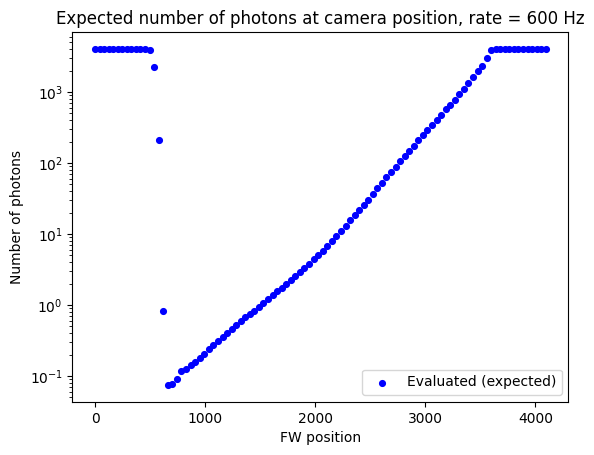

In [91]:
fig, ax = plt.subplots()
plt.scatter(fw600, n_ph_cam_600, c = "b", marker="o",s = 17, label = 'Evaluated (expected)')
ax.set_xlabel("FW position")
ax.set_ylabel("Number of photons")
ax.set_yscale("log")
plt.title("Expected number of photons at camera position, rate = 600 Hz")
ax.legend(loc = 'lower right')
plt.show()

In [92]:
#print(fw600[37])
#for i, item in enumerate(n_ph_cam_600):
    #print(f"{i}:  {item}\n")


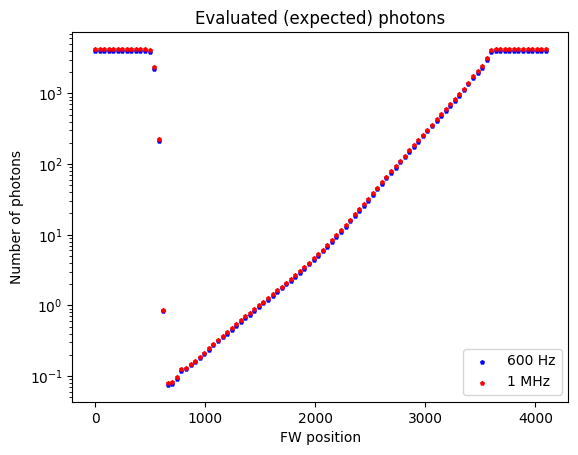

In [93]:
fig, ax = plt.subplots()
plt.scatter(fw600, n_ph_cam_600,marker = "p", c = "b", s = 15., linewidth = 0, label = '600 Hz')
plt.scatter(fw1M, n_photons_1M_exp,  marker="p",s = 15., linewidth = 0, c = "r", label = '1 MHz')
ax.set_xlabel("FW position")
ax.set_ylabel("Number of photons")
ax.set_yscale("log")
plt.title("Evaluated (expected) photons")
ax.legend(loc = 'lower right')
plt.show()

Interpolation 

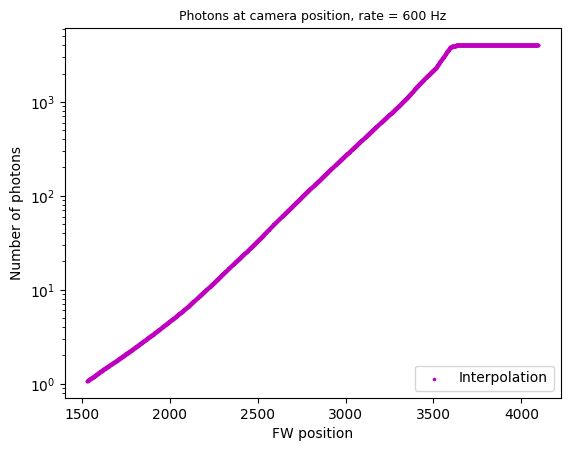

In [94]:
fig, ax = plt.subplots()

pos_int = np.arange(1530.0, 4095.01, 1, dtype=int)
n_ph_interp = np.interp(pos_int, fw1M,n_ph_cam_600 )
plt.scatter(pos_int, n_ph_interp, label = 'Interpolation', marker = ".", s = 10, c = "m")
plt.xlabel("FW position")
ax.set_yscale("log")
#ax.set_ylim(1e-05, 1e05)
plt.ylabel("Number of photons")
plt.title("Photons at camera position, rate = 600 Hz", size = 9)
plt.legend(loc = "lower right")
plt.show()

np.savetxt("d20221207_Laser_Intensity_8_d_3m_rate_600Hz_FW_Laser_interpolation.txt", np.c_[pos_int, n_ph_interp],
header = f"Interpolated values of the expected number of photons at camera position at a rate of 600 Hz and a laser-camera distance of 3 m; n_ph_cam_600 = n_photons_1M_exp * n_ph_laser@600/n_ph_laser@1MHz).\nFW Pos \t \t \t n_photons")


Take a couple of measurements with SiPM to check the calibration method 

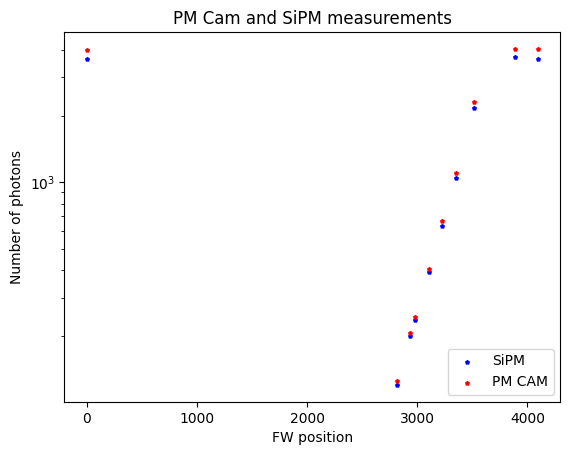

In [95]:
fw = [2812,2936,2978,3102,3226,3515,3350,4095,0,3888]
ph_sipm = [120.3947368,201.7894737,238.0263158,392.3684211,631.5789474,2167.894737,1050,3639.473684,3631.578947,3702.631579]
ph_cam = [125,208,246,405,665,2312,1105,4014,4008,4033]

fig, ax = plt.subplots()
plt.scatter(fw, ph_sipm,marker = "p", c = "b", s = 15., linewidth = 0, label = 'SiPM')
plt.scatter(fw, ph_cam,  marker="p",s = 15., linewidth = 0, c = "r", label = 'PM CAM')
ax.set_xlabel("FW position")
ax.set_ylabel("Number of photons")
ax.set_yscale("log")
plt.title("PM Cam and SiPM measurements")
ax.legend(loc = 'lower right')
plt.show()

In [96]:
perc = 100*(1 - np.divide(ph_sipm,ph_cam))
print(perc)
print(f"Maximum variation = {np.amax(perc)} %")

[3.68421056 2.98582995 3.24133504 3.11890837 5.0257222  6.2329266
 4.97737557 9.33050115 9.39174284 8.19162958]
Maximum variation = 9.39174283932136 %


I see that the variation between the two measurement methods is less then 6% in the region of interest (I took a couple of measurements also when the SiPM has too much light and saturates just to see the maximum variation between the two); the two methods do in general agree, therefore the Powermeter is indeed a reliable device to perform such calibrations. Also, given that the evaluation of n_photons from the SipM data has been done with a number of approximations (PDE, Crosstalk), we will consider the calibration via the PM for further measurements. 
This interpolation results are implemented in the DBM Software.